<a id="top"></a>
# Parameter fit via Bayesian analysis

Use the sweep results conducted with MECSim to get the best fit parameters as well as statistically rigorous error bars for each parameter. 

Bayesian probability updater is used to convert the least squares values output from MECSim analysis tools and stored in the results file into the probability that a particular set of parameters is the correct model for matching the experimental data given that the correct set is within the investigated range.

This method will work for any number of parameters and can use prior probability data to improve the quality of the parameter fits.

This file is structured with the input parameters at the start for ease of use. For those interested the methodology and theory are shown below.


The contents of this notebook are:
- <p><a href="#ref_paras">Parameters</a></p>
- <p><a href="#ref_plot_paras">Plotting parameters (optional)</a></p>
- <p><a href="#ref_readResults">Read least squares results </a></p>
- <p><a href="#ref_bayes_theory">Bayesian analysis theory</a></p>
- <p><a href="#ref_priors">Set priors</a></p>
- <p><a href="#ref_update">Bayesian update</a></p>
- <p><a href="#ref_posteriors">Output posterior probabilities</a></p>
- <p><a href="#ref_error_bars">Calculate error bars for all parameters</a></p>
- <p><a href="#ref_output_error_bars">Output error bars</a></p>
- <p><a href="#ref_plot_posteriors">Plot posterior probabilities and errors</a></p>



<a id="ref_paras"></a>
## Parameters

General parameters and filesnames which will be ignored depending on the options.

In [6]:
# Set an artifical minimum for the metric value(s)
epsilon = 1.0e-6

# set marker label in results header to mark when input variables are finished
header_market = 'S'

# default name for results input file which constains least squares fit metric(s)
results_file_name_default = 'results.txt'

# set how priors done
iLoadPriors = False
priors_filename = "priors_sample.txt"

# save posterior file
iSavePosterior = True
posterior_filename = "posterior.txt"

# save parameter best fits
iSaveParameters = True
opt_para_filename = "opt_parameters.txt"

<a id="ref_plot_paras"></a>
## Plotting parameters (optional)

Plot a contour plot for the final probabilities against two parameters selected by their column number in the results file.

In [7]:
# Plot output to png, pdf files)
iPlotOutput = True
# interactive mode for plotting to screen (turned off if in script mode)
iPlotInteractive = True
# display optimal fit
iPlotFit = True
# display error bars
iPlotErrBars = True
# logscale for probabilities (coloured)
iPlotLogscale = True
# select which columns to plot as parameters (x,y)
ix = 0
iy = 1

## Load packages

In [8]:
# load system functions for inputting arguments at command line
import sys
# load numpy
import numpy as np
# load interpolation function that supports irregular grids
from scipy.interpolate import NearestNDInterpolator
# load plotting functions if requested
if(iPlotOutput):
    from matplotlib  import cm
    import matplotlib.pyplot as plt
    import matplotlib.mlab as ml

## Results file name

Determine results file name. There are two options:

1. this file is run from the command line, so the first argument is the name of this python file (py rather than ipynb).
2. running in interactive mode - through a jupyter notebook say. In which case we use the default file name set above.

In [9]:
print len(sys.argv)
print sys.argv
if(sys.argv[0]=='BayesianAnalysis.py'):
    # next should be the file name
    results_file_name = sys.argv[1]
    iPlotInteractive = False
else:
    results_file_name = results_file_name_default

3
['C:\\Users\\gk250818\\AppData\\Local\\Continuum\\Anaconda2\\lib\\site-packages\\ipykernel\\__main__.py', '-f', 'C:\\Users\\gk250818\\AppData\\Roaming\\jupyter\\runtime\\kernel-09296f8c-8b47-44c3-8893-e5278b46646b.json']


<a id="ref_readResults"></a>
## Read results data

Use header line to determine the number of input parameters compared to the number of result values

In [10]:
lines = [line.rstrip('\n') for line in open(results_file_name)]

# first line is header line (remove $ from marker as well)
header_line = lines[0].replace('$', '')
header_line = header_line.split(',')

# find index for the results metric column header
output_first_index = header_line.index(header_market)

# total length of data file (less header)
n_data = len(lines)-1

# loop read over data
input_data = []
for i in range(n_data):
    input_data.append(np.fromstring(lines[i+1].strip(), dtype=float, sep=','))
input_data = np.array(input_data)
n_cols = np.shape(input_data)[1]

Sort by parameters first - in case of an issue with loading priors later

In [11]:
input_data = input_data[input_data[:,(output_first_index-1)].argsort()]
for i in np.arange(output_first_index-2, -1, -1): # excludes stop so final is 0
    input_data = input_data[input_data[:,0].argsort(kind='mergesort')]

Collect into parameters and least squares metrics

In [12]:
input_parameters = input_data[0:n_data, 0:(output_first_index)]
input_metrics    = input_data[0:n_data, output_first_index:n_cols]

<a id="ref_bayes_theory"></a>
## Bayesian analysis

Conceptually each set of parameters $x_i$ is treated as a different model $M_i$ that can potentially fit the experimental data from a given experiment $D_k$. This experimental data can either be the least squares fit for a single harmonic (or dc) or the resulting metric when all harmonic fit data is combined via respective weights.

We seek to find the probability of each model ($M_i$) given the input of new experimental data ($D_k$), which we write as $P(M_i|D_k)$.

To update the indiviual probabilites for each model via [Bayes theory](https://en.wikipedia.org/wiki/Bayes%27_theorem). Since we have so many potential models (each set of parameters tested) we can write Bayes theorem as:

$$
P(M_i|D_k) = \frac{ P(D_k | M_i) P(M_i) } { \sum_j P(D_k | M_j) P(M_j) }
$$
where the probability of the data given the model is related to the least squares metric comparing the experimental current response data ($D_k$) to the simulated current ($S_{ki}$) for the parameters ($x_i$) via
$$
P(D_k | M_i) \propto \frac{1}{S_{ki}}.
$$

Since the least squares metric can return zero for a perfect fit then we need to add a small term to ensure the probability does not go to infinity. Also we can remove the proportionality constant since any choice we make for it cancels out when we apply the form for Bayes theorem above. Thus
$$
P(D_k | M_i) = \frac{1}{S_{ki} + \epsilon}.
$$

where $\epsilon$ is much smaller than one, set as **epsilon** $10^{-6}$ above.

In applying this theorem the **prior** ($P(M_i)$) is the pre-existing belief that a given model ($M_i$) is correct. Adding new comparison data will update our beliefs and output the **posterior** probabilities ($P(M_i|D_k)$). If we have multiple data sets then the posterior values from our first set ($k=1$) can be used as the priors for the next set ($k=2$) and so on, further improving the accuracy of the posterior probabilities.

Note that these probabilities will always sum to one $\sum_i P(M_i) = 1$ which implicitly assumes that the true model is somewhere within the parameter range input. This could result in misleading interpretations if, for example, the true model was for parameters well outside this range or a different electrochemical mechanism all together.

Back to <a href="#top">top</a>.

<a id="ref_priors"></a>
## Priors

Vector of probabilities with the same length as the number of parameter combinations (**n_data**)

Loading priors is more tricky. Fine if all in the same grid where all **input_parameters** are the same.

How do we update sets where we have no new data while correctly updating others?

For now assume same grid! Still need to order first

Back to <a href="#top">top</a>.

In [13]:
if(iLoadPriors):
    print('Loading priors from ', priors_filename)
    priors_full = np.loadtxt(priors_filename, delimiter=",")
    priors_full = priors_full[priors_full[:,(output_first_index-1)].argsort()]
    for i in np.arange(output_first_index-2, -1, -1): # excludes stop so final is 0
        priors_full = priors_full[priors_full[:,0].argsort(kind='mergesort')]
    # extract vector in same order as input_parameters
    # FOR NOW MUST HAVE SAME DATA LENGTH
    priors = priors_full[0:n_data, output_first_index:n_cols]
else:
    print('Using uniform priors')
    priors = np.full((n_data, 1), 1./n_data)

Using uniform priors


<a id="ref_update"></a>
## Uses Bayes to update beliefs

Loop over metrics and combine with Bayesian update.

Back to <a href="#top">top</a>.

In [14]:
n_metrics = np.shape(input_metrics)[1]
P_Mi = priors
# get P(D_k | M_i)
for k in range(n_metrics):
    ls_ki = input_metrics[0:n_data, k]
    P_Dk_Mi = 1.0/(ls_ki + epsilon)
    P_Dk_Mi_P_Mi = P_Dk_Mi*np.transpose(P_Mi)
    P_Mi_Dk = P_Dk_Mi_P_Mi / P_Dk_Mi_P_Mi.sum()
    P_Mi = P_Mi_Dk
# transform output into a array of correct length
P_Mi_Dk = np.array(P_Mi_Dk[0,:])

<a id="ref_posteriors"></a>
## Save posteriors

Calculate output posterior

Back to <a href="#top">top</a>.

In [15]:
parameters = input_parameters.reshape(n_data, output_first_index)
values = P_Mi_Dk.reshape(n_data, n_metrics)
posterior = np.concatenate((parameters, values), axis=1)

Output to csv file

In [16]:
if(iSavePosterior):
    np.savetxt(posterior_filename, posterior, fmt='%.8e', delimiter=",")

<a id="ref_error_bars"></a>
## Calculate error bars

For each parameter calculate the standard deviation (each direction) based on the probabilities given all other parameters are fixed at their optimal values.

### Build interpolator function

Interpolate to get the $x_{\pm \sigma}$ for each direction - cut at $x_{min/max}$ to avoid extrapolation to unrealistic values. So if $0 < x < 1$ then $x_{+\sigma}$ and $x_{-\sigma}$ must also be in this range

To determine the probabilities probabilities along each line we use a simple nearest neighbour interpolator in N dimensions. Note that if resolution is poor then the resulting interpolations along each line will be a series of discrete steps. Even in this low resolution extreme we still get quite good values for the error bars.

Back to <a href="#top">top</a>.

In [17]:
interpolator = NearestNDInterpolator(x=parameters, y=values)

### Loop over each paramater

Loop over each parameter along the range of possible values while fixing all other parameters to their optimal values.



In [18]:
n_res = 100
opt_index = np.argmax(P_Mi_Dk)
opt_paras = input_parameters[opt_index,:]
opt_min = np.min(parameters, axis=0)
opt_max = np.max(parameters, axis=0)
opt_para_p = opt_paras.copy()
opt_para_m = opt_paras.copy()
for i in range(len(opt_paras)):
    # create x_i line
    opt_xi = np.linspace(opt_min[i], opt_max[i], num=n_res, endpoint=True)
    val_xi = opt_xi.copy()
    opt_test = opt_paras.copy()
    for j in range(len(opt_xi)):
        opt_test[i] = opt_xi[j]
        val_xi[j] = interpolator(opt_test)
    # scale in xi direction by sum_xi
    sum_xi = np.sum(val_xi)
    val_xi = val_xi/sum_xi
    cum_xi = np.cumsum(val_xi)
    # interpolate for med - 1 st.dev = 0.159
    opt_para_m[i] = np.interp(0.159, cum_xi, opt_xi)
    # interpolate for med + 1 st.dev = 0.841
    opt_para_p[i] = np.interp(0.841, cum_xi, opt_xi)
print("opt-1sd = ", opt_para_m)
print("opt     = ", opt_paras)
print("opt+1sd = ", opt_para_p)


('opt-1sd = ', array([ 0.00822727,  0.2064545 ]))
('opt     = ', array([ 0.01,  0.21]))
('opt+1sd = ', array([ 0.01167172,  0.21334347]))


<a id="ref_output_error_bars"></a>
### Output optimal and errors


Each optimal value for parameter $x_i$ has a row in the output file with a format of:

    parameter label (e.g. 'Ezero'), x_opt, x_opt - 1 standard deviation, x_opt + 1 standard deviation

Back to <a href="#top">top</a>.

In [19]:
if(iSaveParameters):
    # round values
    opt_para_m_out = np.reshape(np.round(opt_para_m, 8), (len(opt_paras), 1))
    opt_paras_out  = np.reshape(np.round(opt_paras,  8), (len(opt_paras), 1))
    opt_para_p_out = np.reshape(np.round(opt_para_p, 8), (len(opt_paras), 1))
    # reshape parameter headers
    para_label = np.reshape(np.array(header_line[0:len(opt_paras_out)]), (len(opt_paras_out), 1))
    # join to single np.array for output
    opt_para_array_out = np.concatenate((para_label, opt_paras_out, opt_para_m_out, opt_para_p_out), axis=1)
    # output to text file (since some text then set format to string for all - numbers come out as %f without problem)
    np.savetxt(opt_para_filename, opt_para_array_out, fmt='%s', delimiter=",")

<a id="ref_plot_posteriors"></a>
## Plot posteriors (and error bars)

### Plotter setup


Back to <a href="#top">top</a>.

In [20]:
if(iPlotOutput):
    # set names
    x_name = header_line[ix]
    y_name = header_line[iy]

    # select data for plot with Bayesian probability
    x = input_parameters[0:n_data, ix]
    y = input_parameters[0:n_data, iy]
    z = P_Mi_Dk

    # find min/max for plotting variables
    xplotmin = np.min(x)
    xplotmax = np.max(x)
    yplotmin = np.min(y)
    yplotmax = np.max(y)

    # optimal value and error bars
    x_opt = opt_paras[ix]
    y_opt = opt_paras[iy]
    x_err_m = x_opt - opt_para_m[ix]
    y_err_m = y_opt - opt_para_m[iy]
    x_err_p = opt_para_p[ix] - x_opt
    y_err_p = opt_para_p[iy] - y_opt    

### Plotting parameters

Overall resolution, aesthetic buffer around plot region and enter interactive mode (if requested)

In [21]:
if(iPlotOutput):
    # set overall data resolution
    ny, nx = 100, 100

    # buffer settings
    bufFactor = 100.
    bufX = (xplotmax - xplotmin)/bufFactor
    bufY = (yplotmax - yplotmin)/bufFactor

    # set to interactive mode
    if(iPlotInteractive):
        %matplotlib inline

### Output plot

Output to png and pdf - also to screen if interactive mode set above

The default aesthetic settings and axes labels can be changed here.

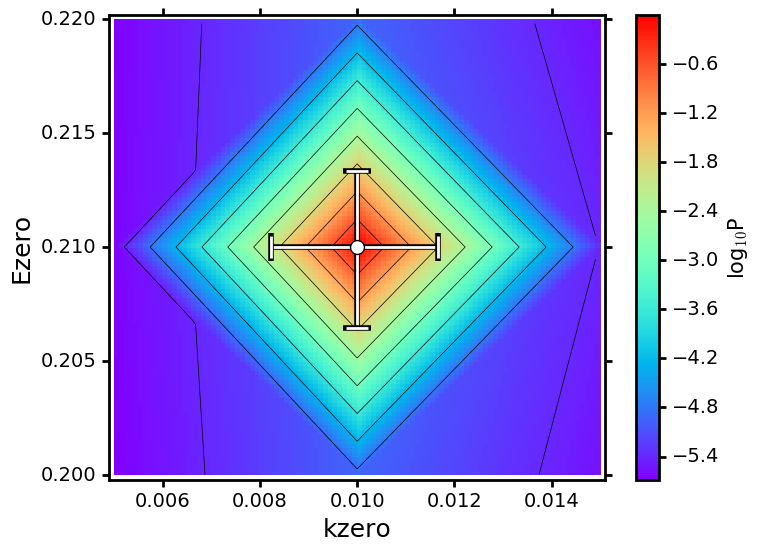

In [22]:
if(iPlotOutput):
    deltax = (xplotmax - xplotmin)/float(nx)
    deltay = (yplotmax - yplotmin)/float(ny)
    xmin = xplotmin-bufX
    xmax = xplotmax+bufX
    ymin = yplotmin-bufY
    ymax = yplotmax+bufY
    xi = np.arange(xmin-bufX, xmax+bufX, deltax)
    yi = np.arange(ymin-bufY, ymax+bufY, deltay)
    # convert to log(z) if requested
    if(iPlotLogscale):
        z = np.log10(z)
    #zi = ml.griddata(x, y, zlog, xi, yi, interp='nn') # 'nn' for incomplete data; 'linear' if complete
    zi = ml.griddata(x, y, z, xi, yi, interp='linear') # 'nn' for incomplete data; 'linear' if complete
    #zi = ml.griddata(x, y, zlog, xi, yi, interp='linear') # 'nn' for incomplete data; 'linear' if complete

    plt.figure(figsize=(8,6),dpi=100)
    plt.rcParams['xtick.major.size'] = 5
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['xtick.minor.width'] = 2
    plt.rcParams['ytick.major.size'] = 5
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['ytick.minor.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['contour.negative_linestyle'] = 'solid'
    plt.rcParams['xtick.direction'] = 'out'
    plt.rcParams['ytick.direction'] = 'out'
    plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    CS = plt.contour(xi, yi, zi, 10, linewidths = 0.5, colors = 'k')
    # Define a class that forces representation of float to look a certain way
    # This remove trailing zero so '1.0' becomes '1'
    class nf(float):
        def __repr__(self):
            str = '%.2f' % (self.__float__(),)
            if str[-1] == '0':
                return '%.2f' % self.__float__()
            else:
                return '%.2f' % self.__float__()

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    plt.pcolormesh(xi, yi, zi, cmap = plt.get_cmap('rainbow'))
    if(iPlotLogscale):
        plt.colorbar().set_label(label='log$_{10}$P',size=15)
    else:
        plt.colorbar().set_label(label='Probability',size=15)
    # plot error bars
    if(iPlotErrBars):
        plt.errorbar(x=x_opt, y=y_opt, xerr=[[x_err_m], [x_err_p]], yerr=[[y_err_m], [y_err_p]], 
                     fmt='--o', ecolor='k', elinewidth=4, capsize=10, capthick=4)
        plt.errorbar(x=x_opt, y=y_opt, xerr=[[x_err_m], [x_err_p]], yerr=[[y_err_m], [y_err_p]], 
                     fmt='--o', ecolor='w', elinewidth=2, capsize=8, capthick=2)
    else: # label the contours
        plt.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=12)
    # plot optimal values
    if(iPlotFit):
        plt.scatter(x_opt, y_opt, marker = 'o', c = 'white', s = 100, zorder = 10)

    
    # set x/y limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    # change x/y labels
    plt.xlabel(x_name, fontsize=18)
    plt.ylabel(y_name, fontsize=18)
    # save figures to PDF and png
    plt.savefig("bayesian_plot.pdf", dpi=400)
    plt.savefig("bayesian_plot.png", dpi=400)
    if(iPlotInteractive):
        plt.show()